In [1]:
import cv2
from PIL import Image
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms, ToTensor
from torch.nn import functional as F
import os
import pandas as pd

In [2]:
!pip install d2l
from d2l import torch as d2l

  Obtaining dependency information for d2l from https://files.pythonhosted.org/packages/8b/39/418ef003ed7ec0f2a071e24ec3f58c7b1f179ef44bec5224dcca276876e3/d2l-1.0.3-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 57.9 MB/s eta 0:00:00
  Obtaining dependency information for matplotlib==3.7.2 from https://files.pythonhosted.org/packages/c2/da/a5622266952ab05dc3995d77689cba600e49ea9d6c51d469c077695cb719/matplotlib-3.7.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 40.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.7/111.7 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 80.4 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.3
    Uninstalling numpy-1.24.3:
      Successfully uninstalled numpy-1.24.3
  Attempting uninstall: scipy
    Found existing installation: SciPy 1.11.4
    Un

<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [3]:
train_transformer = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

class CustomImageDataset(Dataset):
    def __init__(self, mark_file='', img_dir='', transform=None, target_transform=None, extra_transform = None):
        self.img_labels = pd.read_csv(mark_file, index_col=0) # 训练标注文件
        self.img_dir = img_dir  # 文件目录
        self.transform = transform
        self.target_transform = target_transform
        self.extra_transform = extra_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        # image = read_image(img_path)
        image = Image.open(img_path)
        label = self.img_labels.iloc[idx, 1]

        #此处修改了
        if 'gray' in self.img_labels.iloc[idx, 0]:
            image = self.extra_transform(image)
        elif self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label
 

In [4]:
# 已经读取成train.csv
read_path = r'/kaggle/input/a-apart-of-data/data/train'
dict_mark = {'image':[],'label':[]}
for i in os.listdir(read_path):
    specific_path1 = os.path.join(read_path,str(i))
    categories = int(i)
    for j in os.listdir(specific_path1):
        specific_path2 = os.path.join(specific_path1, str(j))
#         print('categories：', categories,'|path:',specific_path2)
        dict_mark['image'].append(specific_path2)
        dict_mark['label'].append(categories)

pd.DataFrame(dict_mark).to_csv('train.csv')

In [5]:
# 已经读取成train.csv
read_path = r'/kaggle/input/a-apart-of-data/data/test'
dict_mark = {'image':[],'label':[]}
for i in os.listdir(read_path):
    specific_path1 = os.path.join(read_path,str(i))
    categories = int(i)
    for j in os.listdir(specific_path1):
        specific_path2 = os.path.join(specific_path1, str(j))
        dict_mark['image'].append(specific_path2)
        dict_mark['label'].append(categories)

pd.DataFrame(dict_mark).to_csv('test.csv')

In [6]:
import torchvision

from torch import nn
v0 = torchvision.models.resnet18(weights = None)

v0.fc = nn.Linear(v0.fc.in_features,100)
nn.init.xavier_uniform_(v0.fc.weight)

Parameter containing:
tensor([[ 0.0066,  0.0112,  0.0929,  ...,  0.0032, -0.0101,  0.0867],
        [ 0.0126,  0.0931, -0.0398,  ...,  0.0894,  0.0032, -0.0412],
        [ 0.0113,  0.0914, -0.0873,  ..., -0.0614,  0.0358, -0.0518],
        ...,
        [-0.0675,  0.0406,  0.0462,  ...,  0.0328,  0.0243, -0.0101],
        [-0.0315, -0.0199, -0.0314,  ..., -0.0483,  0.0646, -0.0481],
        [ 0.0218,  0.0236, -0.0574,  ..., -0.0899, -0.0152,  0.0112]],
       requires_grad=True)

In [7]:
data_font = CustomImageDataset('train.csv', '',train_transformer)
data_train = DataLoader(data_font, batch_size=128*4, shuffle=True)
data_font1 = CustomImageDataset('test.csv', '',train_transformer)
data_test = DataLoader(data_font1, batch_size=128*4, shuffle=True)

In [8]:
device = d2l.try_gpu()

loss 0.034, train acc 0.998, test acc 0.710
653.9 examples/sec on cuda:0


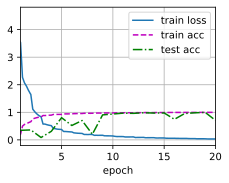

In [9]:
d2l.train_ch6(v0,data_train,data_test,20,0.08,device)
torch.save(v0.state_dict() , 'res18.pth' )